In [6]:
import sys
sys.path.append("/home/bl9/gempy/")
sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

from gempy import Topology

import vtk

In [7]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50],
                         #path_f = "/home/bl9/gempy//input_data/Fab_TrapModel_Foliations.csv",
                         #path_i = "/home/bl9/gempy//input_data/Fab_TrapModel_Points.csv")
                         path_f = "./input_data/FabLessPoints_Foliations.csv",
                         path_i = "./input_data/FabLessPoints_Points1.csv")
geo_data.n_faults = 1

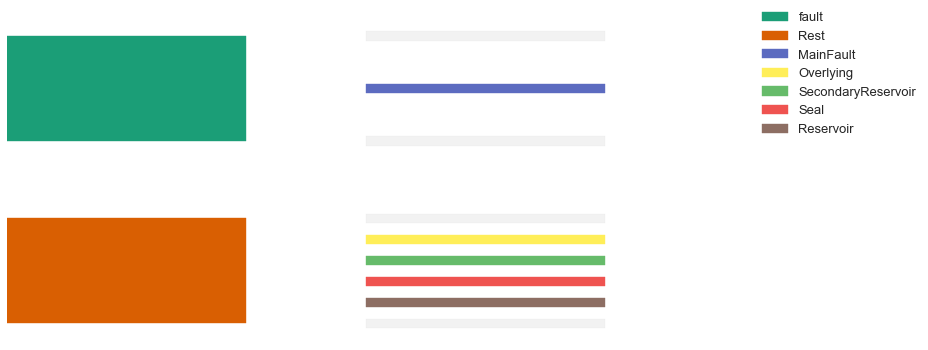

In [8]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Reservoir', 'Seal', 'SecondaryReservoir', 'Overlying')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'Overlying', 'SecondaryReservoir', 'Seal','Reservoir',
                                         ])

In [51]:
#geo_data.set_formation_number(['MainFault','Reservoir','Seal','SecondaryReservoir','Overlying'])

In [7]:
#gp.data_to_pickle(geo_data, 'BasicFault') #saving data to pickle

In [8]:
#geo_data.interfaces.head()
#gp.get_data(geo_data)

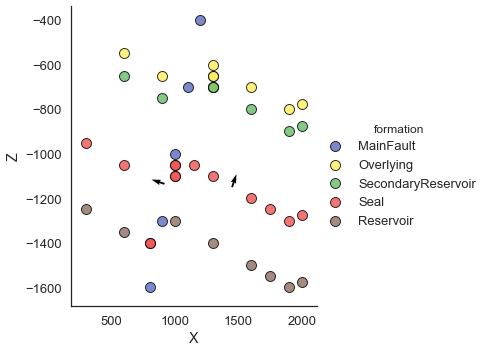

In [5]:
gp.plot_data(geo_data)

In [158]:
gp.plot_data_3D(geo_data)

In [9]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [10]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [8]:
# CREATING SURFACES FOR LAYERS
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Reservoir']))
overlying_surf, overlying_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Overlying']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['SecondaryReservoir']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Seal']))

In [11]:
print(res_surf.shape, seal_surf.shape, sec_res_surf.shape, overlying_surf.shape)

(4290, 3) (4252, 3) (4070, 3) (4426, 3)


In [111]:
#geo_data.get_formation_number().keys()

In [112]:
#geo_data.get_formations()

In [10]:
geo_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'Overlying': 2,
 'Reservoir': 5,
 'Seal': 4,
 'SecondaryReservoir': 3}

In [11]:
#opacity = float(1)
gp.plot_surfaces_3D(geo_data, [overlying_surf, sec_res_surf, seal_surf, res_surf], 
                    [overlying_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=True)

In [186]:
#sys.path.append("/home/bl9/gempy/gempy/")
#
#import Visualization 
#importlib.reload(Visualization)

<module 'Visualization' from '/home/bl9/gempy/gempy/Visualization.py'>

In [189]:
#w = Visualization.vtkVisualization(interp_data.geo_data_res, real_time=True )
#w.set_surfaces([overlying_surf, sec_res_surf, seal_surf, res_surf], 
#               [overlying_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp],
#               #formations_names_l, formation_numbers_l,
#                )
#w.interp_data  = interp_data
#if True:
#    w.set_interfaces()
#    w.set_foliations()
#w.render_model()

In [79]:
gp.plot_surfaces_3D(geo_data, [res_surf], [res_surf_simp])

In [12]:
interp_data.get_formation_number()

{'DefaultBasement': 0,
 'MainFault': 1,
 'Overlying': 2,
 'Reservoir': 5,
 'Seal': 4,
 'SecondaryReservoir': 3}

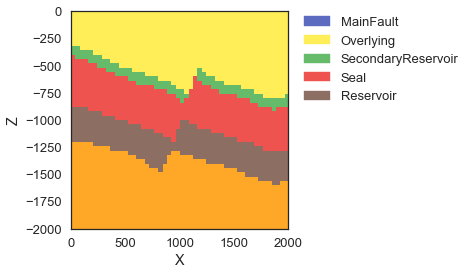

In [6]:
#%matplotlib notebook
%matplotlib inline
gp.plot_section(geo_data, lith_sol[0,0], 25) #plot_data=True)

In [11]:
resolution = 50
model_size = 2000
scale_factor = (model_size/resolution) #original grid in [m]/grid resolution --> what if model not cubic?

In [12]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

In [9]:
# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
def fw_thicknesses(interp_data):
    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
    
    rescale_f = interp_data.rescaling_factor
    
    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
    points_fw = points_fw[y_mid]
    
    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
    
    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

# Hanging wall at X = 600 and Y = 1000
def hw_thicknesses(interp_data):
    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
    
    rescale_f = interp_data.rescaling_factor
    
    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
    points_hw = points_hw[y_mid]
    
    hw_rb_z = points_hw[res_bot_cond]['Z']
    hw_sb_z = points_hw[seal_bot_cond]['Z']
    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
    hw_ob_z = points_hw[over_bot_cond]['Z']
    
    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
    return hw_res_th, hw_seal_th, hw_sec_res_th

In [10]:
# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [13]:
# SPILL AND LEAK POINT FUNCTIONS

# Finding the spill point
def spill_point(res_surface):
    mini = argrelextrema(res_surface[:,2], np.less, order=10)
    minima = np.array(list(zip(np.take(res_surface[:,1], mini[0]), np.take(res_surface[:,0], mini[0]), np.take(res_surface[:,2], mini[0]))))
    fault_thresh = minima[:,1] > 700 #taking only relevant side by setting a threshold visually estimated, best: 20
    spill_min_line = minima[fault_thresh]
    spill_pos = np.array(np.argmax(spill_min_line[:,2]))
    spill_z = np.take(spill_min_line[:,2], spill_pos)
    spill_p = np.array([np.take(spill_min_line[:,1], spill_pos), np.take(spill_min_line[:,0],
                                spill_pos), np.take(spill_min_line[:,2], spill_pos)])
    
    # Horizontal plane defined by z-pos of spill
    if True:
        spill_bottom = np.ones_like(res_surface)
        spill_bottom[:,0] = res_surface[:,0]
        spill_bottom[:,1] = res_surface[:,1]
        spill_bottom[:,2] = spill_z    
    
    return spill_z, spill_p, spill_min_line, spill_bottom

# Finding the leak point ( critically inefficient method! takes 10s!)
def leak_point(res_surface):
    counter = 0
    # Creating empty lists and arrays to save values
    xvals = []
    yvals = []
    zvals = []
    leak_min = np.empty((0,3), dtype=int)
    #leak_min = np.empty([3,], dtype=int)
    
    for i in np.unique(res_surface[:,1]):
        
    #while counter < model_size:
        #print(counter)
        for e in res_surface:
            # Looking at a slice along y-axis for y = e[1] = counter, 
            # and appending x,y,z-values into lists
            # This is a way of RESORTING the array as needed
            #if int(e[1]) == counter:
            if e[1] == i:
                xvals.append(e[0])
                yvals.append(e[1])
                zvals.append(e[2])
            
        # Saving x,y,z-values as lists/arrays      
        zvals = np.array(zvals)
        yvals = np.array(yvals)
        xvals = np.array(xvals)

        # Looking fore minima positions in z-array
        min_pos = argrelextrema(zvals, np.less, order=10)
        
        # Saving x,y,z-positions of minima
        ypos = yvals[min_pos]
        xpos = xvals[min_pos]
        mins = zvals[min_pos]
        
        # Condition: Check if any minimum was found and if any data is given at y = counter
        # If no minimum found, restart loop at next iteration
        # This way, we can work with the data that coesn't cover every 1 step along the model
        # (such as the surface vertices)
        if len(mins) == 0:
            counter += 1
            #lists have to be emptied again
            xvals = []
            yvals = []
            zvals = []
            continue
        
        #np.append(leak_min, mins) -----> what did I use this for?
        
        # Create and array element to save coordinates of minima
        mins_pos = np.array(list(zip(xpos, ypos, mins)))
        # Save minima of slice into array of ALL minima
        leak_min = np.vstack((leak_min, mins_pos))

        # Empty lists for next iteration
        xvals = []
        yvals = []
        zvals = []
    
        counter += 1
        
    #leak_min = np.delete(leak_min, 0, 0) #what does this do???
    
    # Result of the loop above is one or SEVERAL lines of minima ("leak lines")
    # only want to look at the line bordering the fault surface
    # need for a general function/method to limit to only that line!
    # For now: Taking only relevant side by setting a threshold that is visually estimated
    near_fault_thresh = leak_min[:,0] < 1500
    leak_line = leak_min[near_fault_thresh]
    
    # The highest point of the leak line is the leak point!
    leak_pos = np.array(np.argmax(leak_line[:,2]))
    leak_z = np.take(leak_line[:,2], leak_pos)

    # Full coordinates of the leak point as array element
    leak_p = np.array([np.take(leak_line[:,1], leak_pos), np.take(leak_line[:,0], leak_pos), np.take(leak_line[:,2], leak_pos)])
    
    # Creating a horizontal plane defined by the leak point z-position, in shape of res_surface
    leak_bottom = np.ones_like(res_surface)
    leak_bottom[:,0] = res_surface[:,0]
    leak_bottom[:,1] = res_surface[:,1]
    leak_bottom[:,2] = leak_z
   
    return leak_z, leak_p, leak_line, leak_bottom

In [14]:
# MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = bottom_z/scale_factor
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

# Function that sets all voxels of lith_block which are equal (or closest to) to the spill_z
# horizontal as belonging to the overlying seal 
# (the voxels is located on the border of reservoir and seal):
def set_spill_to_seal(geo_data, lith, max_z):
    lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]+np.abs(max_z)))
    bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
    lith[bol_lith_spill] = 6
    return lith
        ### Hpw to check in here, if single spill voxel = reservoir (5)??? Need x and y pos?

# Masking that confines the volume to ONLY those reservoir traps (from res_mask)
# that are NOT connected to the borders of the model (open system)
# Traps defined as CLOSED systems
def topo_analysis(lith, fault):
    fig = plt.figure()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    topo = Topology.Topology(lith_pad, fault_pad)
    #topo.draw_section(25)
    topo_block = topo.labels
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    topo_keys = [int(k) for k in topo.lith_to_labels_lot["7"].keys()]
    pad_keys = [int(p) for p in topo.lith_to_labels_lot["8"].keys()]
    #over_keys = [int(o) for o in topo.lith_to_labels_lot["2"].keys()]
    #sec_res_keys = [int(sr) for sr in topo.lith_to_labels_lot["3"].keys()]
    bool_block = np.zeros_like(topo_block)
    # Check for each possible trap section, if it is connected to a border
    for tk in topo_keys:
        print('Checking Section:', tk)
        # Saving enclosed sections as traps
        if topo.check_adjacency(tk, pad_keys[0]) == False:
            print("TRAP FOUND, section:", tk)
            traps.append(tk)
    if traps == []:
        print('No trap found! =(')
    else:
        for i in traps:
            # Creating a mask from the trap sections in the label block
            top_bool = topo_block == i
            bool_block[top_bool] = True
            ### Extra check for juxtaposition with layers above seal
            #if topo.check_adjacency(i, over_keys[0]) == False and topo.check_adjacency(i, sec_res_keys[0]) == False:
            #    print('Trap sealed upwards.')
            #    top_bool = topo_block == i
            #    bool_block[top_bool] = True
            #else: 
            #    print("Juxtaposition, no trap sealing.")
    # Removing padding
    trap_mask = bool_block[1:-1,1:-1,1:-1]
    #plt.imshow(trap_mask[:,25,:].T, origin="lower")
    #plt.show()
    return trap_mask

In [15]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(lith, fault, res_surface, fault_sealing):
    # calculate spill point
    spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
    # calculate leak point
    leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
    
    # Check for "down-to" z-horizon, maximum depth of reservoir
    # Check for fault sealing and subsequent relevance of leak point
    max_z = np.max([spill_z, leak_z])
    if fault_sealing == True:
        if max_z == spill_z:
            print("Spill point defines trap.")
            print("Fault is sealing. Down to spill.")
            bottom_surface = spill_bottom
        else:
            print("Fault leak point above spill point.")
            max_z = spill_z
            print("...but fault sealing. Down to spill.")
            bottom_surface = spill_bottom
    else:
        if max_z == spill_z:
            print("Spill point defines trap.")
            print("Fault is pathway. Down to spill.")
            bottom_surface = spill_bottom
        else:
            print("Fault leak point above spill point.")
            print("Cross-fault leakage. Down to leak.")
            bottom_surface = leak_bottom      
    
    #print('Max_Z:', max_z)
    
    res_nr = lith == 5 #interp_data.get_formation_number()['Reservoir']
    pre_trap_mask = res_mask(lith, fault, max_z, res_nr)
          
    # volume cells for counting
    vol_cells = 0      
    
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anaything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        return 0, lith, bottom_surface, pre_trap_mask
    else:
        lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
                                                            # (incl. outside trap) to formation value = 7  
        if max_z == spill_z:
            lith = set_spill_to_seal(geo_data, lith, max_z)
        
        #test = lith.reshape(125000)                       
        #for i in range(len(test)):                         #to test pre-trap-masking volume
        #    if test[i] == 7:
        #        vol_cells +=1
        #res_vol = ((scale_factor)**3) * vol_cells 
        #print("VOLUME INCLUDING OUTSIDE TRAP:" ,res_vol)
        
        final_trap_mask = topo_analysis(lith, fault)
        lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
        vol_cells = np.count_nonzero(final_trap_mask)
        
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        
        #PLOTTING OF SPILL, LEAK AND BOTTOM POSSIBLE HERE:
        #plot_spill(res_surface, spill_min_line, spill_p)
        #plot_leak(res_surface, leak_line, leak_p)
        #plot_trap(res_surface, bottom_surface, spill_p, leak_p)
        #PRINTING OF SPILL, LEAK:
        #print('Spill_Z:', spill_z)
        #print('Leak_Z:', leak_z)
        
        #return the maximum reservoir volume
        return trap_vol, lith, bottom_surface, final_trap_mask

In [16]:
# PLOTTING FUNCTIONS: Spill and leak point visualization

def plot_spill(res_surface, spill_min_line, spill_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_min_line[:,0], -spill_min_line[:,1], spill_min_line[:,2], c='r', s = 50)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 200)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

def plot_leak(res_surface, leak_line, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-leak_line[:,1], -leak_line[:,0], leak_line[:,2], c='r', s = 50)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 200)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    
def plot_trap(res_surface, bottom_surface, spill_p, leak_p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-bottom_surface[:,1], -bottom_surface[:,0], bottom_surface[:,2], c="r", alpha = 0.05)
    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)

    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()
    

In [17]:
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z']
over_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Overlying']['Z']

res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'])

In [18]:
# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP

z_unc_over = pymc.Normal('z_unc_over_bot', 0, 1./0.0001)
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0, 1./0.0003)
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./0.0005)
z_unc_res_bot = pymc.Normal('z_unc_res_bot', 0, 1./0.0008)

# FAULT SEALING UNCERTAINTY (True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=.5)

In [19]:
res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
    

    

    

#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#

In [20]:
@pymc.deterministic
def interp_unc(value=0, z_unc_res_top = z_unc_res_top):
    new_z = seal_z + z_unc_res_top
    print('Z-Variation:', z_unc_res_top)    
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z
    return interp_data

@pymc.deterministic
def res_th(interp_data=interp_unc):
    rescale_f = interp_data.rescaling_factor
    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
    points_fw = points_fw[y_mid]   
    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

@pymc.deterministic
def volume(interp_data=interp_unc, fault_sealing=fault_sealing):
    lith_sol, fault_sol = gp.compute_model(interp_data)
    lith_block = lith_sol[0,0]
    fault_block = fault_sol[0,0]  
    seal_surf, seal_surf_simp = gp.get_surfaces(
                                          interp_data = interp_data, potential_lith=lith_sol[0,1], 
        potential_fault=fault_sol[0,1], n_formation =  3)
    return max_trap_vol(lith_block, fault_block, seal_surf, fault_sealing)[0]
    
#@pymc.deterministic
#def pos_unc_model(value=0, z_unc_res_top = z_unc_res_top, fault_sealing=fault_sealing):
#
#    new_z = seal_z + z_unc_res_top
#    print('Z-Variation:', z_unc_res_top)
#    #print('new', new_z)
#    #print(res_z)
#    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z
#        
#    lith_sol, fault_sol = gp.compute_model(interp_data, get_potential_at_interfaces=False)
#    lith_block = lith_sol[0,0]
#    fault_block = fault_sol[0,0]  
#    seal_surf, seal_surf_simp = gp.get_surfaces(
#                                          interp_data = interp_data, potential_lith=lith_sol[0,1], 
#        potential_fault=fault_sol[0,1], n_formation =  3)#(interp_data.get_formation_number()['Seal']))
#
#    max_vol, lith_sol[0,0], bottom, trap = max_trap_vol(lith_block, fault_block, seal_surf, fault_sealing)
#    
#    print("Maximum reservoir volume: %s m続" % max_vol)
#    gp.plot_section(geo_data, lith_sol[0,0], 25, plot_data =1)
#    
#    #gp.plot_section(geo_data, sol[0, 0,:], 23
#    #                , plot_data=1, direction='x')
#  
#    #gp.plot_surfaces_3D(geo_data, [res_surf], 
#    #                [res_surf_simp], 
#    #                ['Reservoir'], [3])
#    return lith_sol, fault_sol, max_vol, interp_data

Z-Variation: -0.021015326078381212


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Spill point defines trap.
Fault is sealing. Down to spill.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 13
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16


In [18]:
#@pymc.deterministic
#def fw_th(interp_data=pos_unc_model[3]):
#    return fw_thicknesses(interp_data)
#
#@pymc.deterministic
#def hw_th(interp_data=pos_unc_model[3]):
#    return hw_thicknesses(interp_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean

In [206]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)

In [21]:
iterations = 10

In [22]:
model = pymc.Model([interp_unc, z_unc_res_top, fault_sealing, volume, res_th])

In [23]:
M = pymc.MCMC(model)
M.sample(iter=iterations)

Z-Variation: -0.016766714853580573


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Spill point defines trap.
Fault is pathway. Down to spill.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
 [-------          20%                  ] 2 of 10 complete in 2.5 secZ-Variation: 0.020361486515021097
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 10
Checking Section: 11
TRAP FOUND, section: 11
Checking Section: 12
Checking Section: 15
TRAP FOUND, section: 15
 [-----------      30%                  ] 3 of 10 complete in 5.4 secZ-Variation: -0.008472021832661561
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 19
TRAP FOUND, section: 19
 [---------------  40%                  ] 4 of 10 complete in 7.9 secZ-Variation: 0.006430163678222086
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
 [-----------------50%                  ] 5 of 10 complete in 10.4 secZ-Variation: 0.004337933176748757
Spill point defines trap.

In [24]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
trap_volume_trace = M.trace('volume')[:]

fw_th_trace = M.trace('res_th')[:]
#hw_th_trace = M.trace('hw_th')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

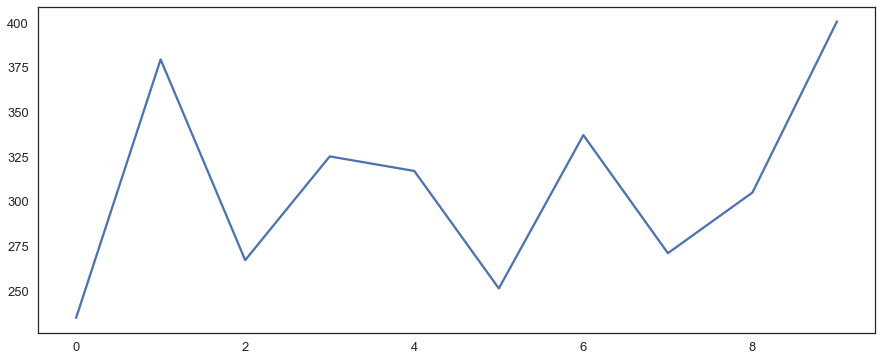

In [25]:
fw_res_trace = fw_th_trace[:,0]
plt.plot(fw_res_trace)

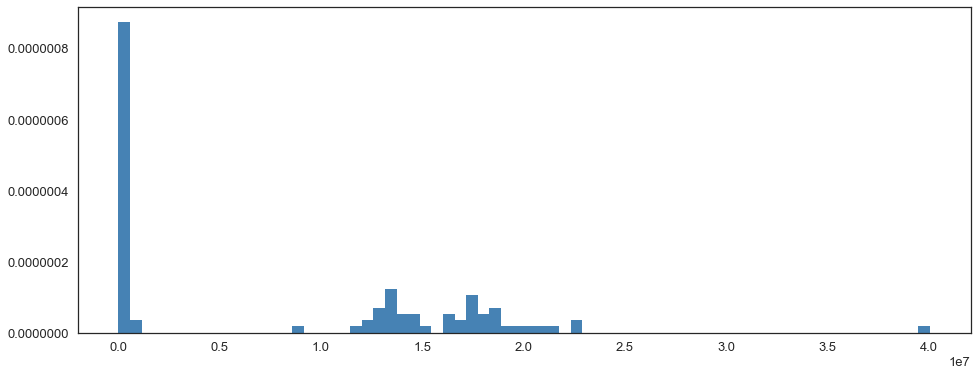

In [278]:
figsize(16, 6)

_hist1 = plt.hist(trap_volume_trace[:,2], bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [184]:
@pymc.deterministic
def model_unc_all(value=0, z_unc_over = z_unc_over, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_res_bot = z_unc_res_bot, fault_sealing=fault_sealing):
    
    new_z_over = over_z + z_unc_over
    new_z_sec_res = sec_res_z + z_unc_seal_top
    new_z_res_top = seal_z + z_unc_res_top
    new_z_res = res_z + z_unc_res_bot
    
    print('Z-Variations:', z_unc_over, z_unc_seal_top, z_unc_res_top, z_unc_res_bot)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Overlying'] = new_z_over
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'] = new_z_sec_res
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z_res_top
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z_res
   
    lith_sol, fault_sol = gp.compute_model(interp_data, get_potential_at_interfaces=False)
    lith_block = lith_sol[0,0]
    fault_block = fault_sol[0,0]  
    seal_surf, seal_surf_simp = gp.get_surfaces(
                                          interp_data = interp_data, potential_lith=lith_sol[0,1], 
        potential_fault=fault_sol[0,1], n_formation = 3)# (interp_data.get_formation_number()['Seal']))
    
    max_vol, lith_sol[0,0], bottom, trap = max_trap_vol(lith_block, fault_block, seal_surf, fault_sealing)
    
    print("Maximum reservoir volume: %s m続" % max_vol)
    #gp.plot_section(geo_data, lith_sol[0,0], 25, plot_data =1)
    
    #gp.plot_section(geo_data, sol[0, 0,:], 23
    #                , plot_data=1, direction='x')
  
    #gp.plot_surfaces_3D(geo_data, [res_surf], 
    #                [res_surf_simp], 
    #                ['Reservoir'], [3])
    return lith_sol, fault_sol, max_vol, interp_data

Z-Variations: 0.0005184444624180411 0.03041324555848724 0.0005563365792353097 -0.049485830549091996


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.8374119760173926e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


Spill point defines trap.
Fault is sealing. Down to spill.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 39
No trap found! =(
Maximum reservoir volume: 0.0 m続


In [185]:
@pymc.deterministic
def fw_th(interp_data=model_unc_all[3]):
    return fw_thicknesses(interp_data)

@pymc.deterministic
def hw_th(interp_data=model_unc_all[3]):
    return hw_thicknesses(interp_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Boolean

In [188]:
iterations = 10
model2 = pymc.Model([model_unc_all, z_unc_over, z_unc_seal_top, 
                     z_unc_res_top, z_unc_res_bot, fault_sealing, fw_th, hw_th])

In [189]:
M2 = pymc.MCMC(model2)
M2.sample(iter=iterations)

KeyError: 0

In [19]:
over_unc_trace = M2.trace('z_unc_over_bot')[:]
sec_res_trace = M2.trace('z_unc_seal_top')[:]
res_top_unc_trace = M2.trace('z_unc_res_top')[:]
res_bot_unc_trace = M2.trace('z_unc_res_bot')[:]
fault_sealing_trace = M2.trace('fault_sealing_unc')[:]
trap_volume_trace = M2.trace('model_unc_all')[:]

fw_th_trace = M2.trace('fw_th')[:]
hw_th_trace = M2.trace('hw_th')[:]

In [ ]:
#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing_trace[j] == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

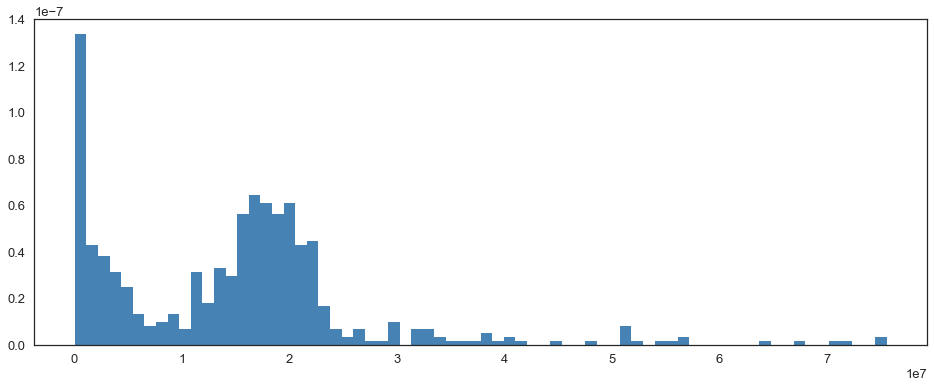

In [20]:
figsize(16, 6)
volumes = trap_volume_trace[:,2]
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [21]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
        return loss_s

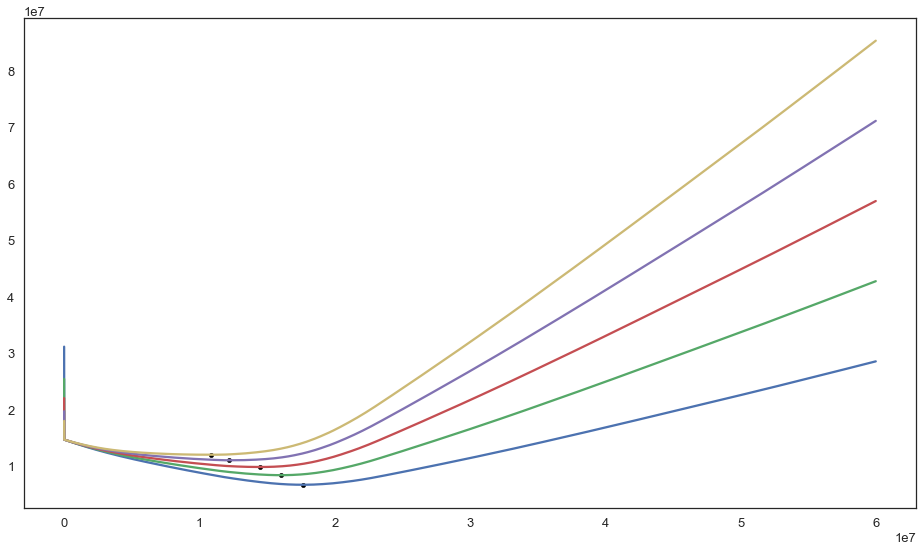

In [22]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [1]:
### TEST SITE
#new_z_sec_res = sec_res_z + z_sec_res_top
#new_z_seal = seal_z + z_seal_top
#new_z_res = res_z + z_res_top
#new_z_over = over_z + z_over_top
#
#print('Z-Variations:', z_sec_res_top, z_seal_top, z_res_top, z_over_top)
#interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'] = new_z_sec_res
#interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal'] = new_z_seal
#interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'] = new_z_res
#interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Overlying'] = new_z_base
#
#sol, pot = gp.compute_model(interp_data, get_potential_at_interfaces=True)
#
#res_surf, res_surf_simp = gp.get_surfaces(potential_block=sol[0, 1,:], 
#                                      interp_data = interp_data, n_formation = (interp_data.get_formation_number()['Reservoir']),)
#
#lith_block = sol[0, 0,:]
#fault_block = sol[0, 2,:]
#
#spill_z, spill_p, spill_line, spill_bottom = spill_point(res_surf)
#leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surf)
#
#print('Spill_Z:', spill_z)
#print('Leak_Z:', leak_z)
#
#plot_spill(res_surf, spill_line, spill_p)
#plot_leak(res_surf, leak_line, leak_p)
#        
#max_vol, sol[0, 0,:], bottom, trap = max_res_vol(lith_block, fault_block, res_surf)
#
##plot_trap(res_surf, bottom, spill_p, leak_p)
##print("Bottom_Z:", bottom[1,2])
#
#print("Maximum reservoir volume: %s m続" % max_vol)
#gp.plot_section(geo_data, sol[0, 0,:], 25)

In [26]:
# ADDING THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 10
std2 = 30
std3 = 75

@pymc.stochastic
def res_th_likelihood(value = 0, resunc=res_th):
    return pymc.normal_like(resunc, 250., 1./np.square(std1))


#@pymc.stochastic
#def res_th_likelihood(value = 0, gamma = fw_th[4], delta = fw_th[3]):
#    c = gamma - delta
#    return pymc.normal_like(c, 250., 1./np.square(std1))
#
#@pymc.stochastic
#def seal_th_likelihood(value = 0,  beta = fw_th[5], gamma = fw_th[5]):
#    b = beta-gamma
#    return pymc.normal_like(b, 150., 1./np.square(std2))
#
#@pymc.stochastic
#def sec_res_th_likelihood(value = 0,  alpha = fw_th[6], beta = fw_th[5]):
#    a = alpha-beta
#    return pymc.normal_like(a, 400., 1./np.square(std2))

In [30]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model = pymc.Model([interp_unc, z_unc_res_top, fault_sealing, volume, res_th, res_th_likelihood])

M = pymc.MCMC(model)
M.sample(iter=100)

Z-Variation: -0.04824253858418691


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Spill point defines trap.
Fault is sealing. Down to spill.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
 [                  2%                  ] 2 of 100 complete in 2.5 secZ-Variation: -0.0261186040466675
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
 [-                 3%                  ] 3 of 100 complete in 5.1 secZ-Variation: 0.0034616410331898967
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
 [-                 4%                  ] 4 of 100 complete in 7.6 secZ-Variation: -0.0039255870303067965
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 17
 [-                 5%                  ] 5 of 100 complete in 10.2 secZ-Variation: 0.0037791069624056664
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 16
TR

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Checking Section: 14
Checking Section: 19
TRAP FOUND, section: 19
 [--------         22%                  ] 22 of 100 complete in 52.8 secZ-Variation: -0.015306233051341163
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
 [--------         23%                  ] 23 of 100 complete in 55.3 secZ-Variation: -0.008471724912308947
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
 [---------        24%                  ] 24 of 100 complete in 57.8 secZ-Variation: -0.028165448443549766
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 15
No trap found! =(
 [---------        25%                  ] 25 of 100 complete in 60.2 secZ-Variation: -0.02226941016642668
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 13
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 2

Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 12
TRAP FOUND, section: 12
Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
 [-----------------58%--                ] 58 of 100 complete in 143.5 secZ-Variation: -0.020996025408852675
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 13
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
 [-----------------59%--                ] 59 of 100 complete in 146.0 secZ-Variation: 0.0009923994435092794
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 14
No trap found! =(
 [-----------------60%--                ] 60 of 100 complete in 148.5 secZ-Variation: -0.013751046455346336
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
 [-----------------61%---               ] 61 of 100 complete in 151.0 secZ-Variation: -0.027189

Checking Section: 15
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 18
Checking Section: 22
TRAP FOUND, section: 22
 [-----------------92%--------------    ] 92 of 100 complete in 230.7 secZ-Variation: 0.00696959956755255
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 14
No trap found! =(
 [-----------------93%---------------   ] 93 of 100 complete in 233.1 secZ-Variation: -0.021868170232454222
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 13
Checking Section: 14
Checking Section: 16
TRAP FOUND, section: 16
 [-----------------94%---------------   ] 94 of 100 complete in 235.6 secZ-Variation: -0.015423538689947593
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 12
TRAP FOUND, section: 12
Checking Section: 15
Checking Section: 16
Checking Section: 18
TRAP FOUND, section: 18
 [-----------------95%----------------  ] 95 of 100 complete in 238.1 secZ-Variation: -0.005349944702966018
Spi

In [31]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
trap_volume_trace = M.trace('volume')[:]

fw_th_trace = M.trace('res_th')[:]
resli_trace = M.trace('res_th_likelihood')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

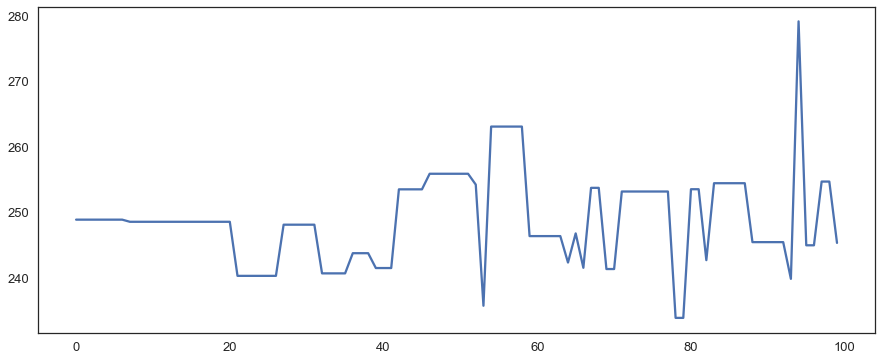

In [32]:
fw_res_trace = fw_th_trace[:,0]
plt.plot(fw_res_trace)